<a href="https://colab.research.google.com/github/VinoJose/Tensorflow/blob/main/05_transfer_learning_in_tensorflow_part_2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 2: Fine-tuning

In [1]:
# Check if we are using a GPU
!nvidia-smi

Tue Jan  4 16:30:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In previous notebooks, we have created a bunch of helper functions, now we could rewrite them all, however this is tedious.
So, it's good idea to put functions you'll want to use again in a script you can download and import into your notebooks.

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-01-04 16:30:56--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-01-04 16:30:56 (71.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## Let's get some data

This time we are going to see how we can use the pretrained models in the `tf.keras.applications` and apply them to our probelm (recognizing images of food).

In [4]:
# Get 10% of training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2022-01-04 16:30:59--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.192.128, 209.85.145.128, 209.85.146.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.192.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   197MB/s    in 0.8s    

2022-01-04 16:31:00 (197 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
unzip_data("10_food_classes_10_percent.zip")

In [6]:
# Check how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [7]:
# Create training and testing directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [8]:
import tensorflow as tf

IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [9]:
train_data_10_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [10]:
# Check out the class names in our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [11]:
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[2.46918365e+02 2.32918365e+02 2.45918365e+02]
   [2.44852036e+02 2.32852036e+02 2.44852036e+02]
   [2.40709183e+02 2.30352036e+02 2.44137756e+02]
   ...
   [1.88623238e+01 1.04235640e+01 4.71441650e+00]
   [2.13570900e+01 1.43570910e+01 8.35709095e+00]
   [1.79694824e+01 1.09694824e+01 4.96948242e+00]]

  [[2.46239792e+02 2.32239792e+02 2.45239792e+02]
   [2.46448990e+02 2.34448990e+02 2.46448990e+02]
   [2.46704086e+02 2.36346939e+02 2.50132660e+02]
   ...
   [1.95561676e+01 8.69902420e+00 2.62759590e+00]
   [2.66428318e+01 1.79183655e+01 1.07805986e+01]
   [2.03621140e+01 1.33621140e+01 7.36211348e+00]]

  [[2.46352036e+02 2.32352036e+02 2.45352036e+02]
   [2.41943878e+02 2.29943878e+02 2.41943878e+02]
   [2.40831635e+02 2.30474487e+02 2.44260208e+02]
   ...
   [2.27346630e+01 9.73466301e+00 2.96939087e+00]
   [2.50714798e+01 1.38011017e+01 7.30108786e+00]
   [2.85101147e+01 1.92958298e+01 1.18672571e+01]]

  ...

  [[1.06071556e+02 9.87143478e+01 1.19500084e+02]
   [1

## Model 0 : Building a transfer learning feature extraction model using Keras Functional API

In [12]:
# 1. Create the base model from pretrained Efficientnet
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model
base_model.trainable = False

# 3. Create input into our model
inputs = tf.keras.layers.Input(shape=(224,224,3), name="input layer")

# 4. If using a model like Resnet50V2, we need to normalize the inputs
#x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base model
x = base_model(inputs)
print(f"Shape after passing to the base_model: {x.shape}")

# 6. Average pool the outputs of the base_model
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine inputs and outputs in to a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model and save the history
history_10_percent = model_0.fit(train_data_10_percent, 
                              epochs=5, 
                              validation_data=test_data,
                              validation_steps=int(0.25*len(test_data)),
                              callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                     experiment_name="10_percent_feature_extraction")])

16719872/16705208 [==============================] - 0s 0us/step
Shape after passing to the base_model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20220104-163111


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/5
24/24 [==============================] - 34s 347ms/step - loss: 1.8309 - accuracy: 0.4280 - val_loss: 1.3357 - val_accuracy: 0.6826
Epoch 2/5
24/24 [==============================] - 6s 254ms/step - loss: 1.1223 - accuracy: 0.7507 - val_loss: 0.9141 - val_accuracy: 0.7845
Epoch 3/5
24/24 [==============================] - 6s 252ms/step - loss: 0.8254 - accuracy: 0.8107 - val_loss: 0.7429 - val_accuracy: 0.8207
Epoch 4/5
24/24 [==============================] - 7s 256ms/step - loss: 0.6855 - accuracy: 0.8267 - val_loss: 0.6717 - val_accuracy: 0.8306
Epoch 5/5
24/24 [==============================] - 9s 353ms/step - loss: 0.5759 - accuracy: 0.8680 - val_loss: 0.6167 - val_accuracy: 0.8372


In [13]:
# Evaluate on full test data
model_0.evaluate(test_data)

79/79 [==============================] - 11s 132ms/step - loss: 0.6155 - accuracy: 0.8340


[0.6155027747154236, 0.8339999914169312]

In [14]:
# Check the layers in our model
for layer_number , layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [15]:
# How about we get a summary of base_model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [16]:
# Summary of our model
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


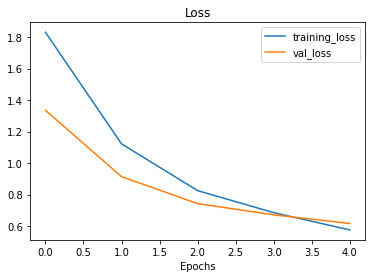

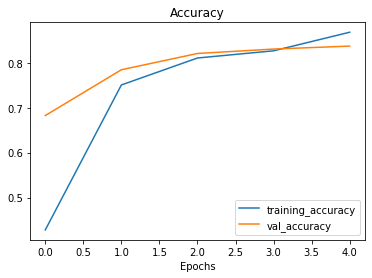

In [17]:
# Let's plot the loss curves
plot_loss_curves(history_10_percent)

## Getting a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer.

We have a tensor after our model goes through `base_model` of shape (None,7,7,1280).

But when it passes through GlobalAveragePooling2D layer, it turns into (None,1280).

Let's use a similar shaped tensor (None,4,4,3) and then pass it through GlobalAveragePooling2D layer.

In [18]:
# Define input shape
input_shape = (1,4,4,3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor: \n {input_tensor}\n")

# Pass the tensor through Global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled tensor:\n{global_average_pooled_tensor}\n")

# Check the shape of different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of output tensor: {global_average_pooled_tensor.shape}")

Random input tensor: 
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled tensor:
[[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of output tensor: (1, 3)


In [19]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

## Running a series of transfer learning experiments

We have seen incredible results transfer learning can get with only 10% of training data, but how does it go with 1% of training data.. how about we set up a bunch of experiments and find out:

1. `model_1` - Use feature extraction transfer learning with 1% of training data with data augmentation.
2. `model_2` - Use feature extraction transfer learning with 10% of training data with data augmentation.
3. `model_3` - Use fine-tuning transfer learning with 10% of training data with data augmentation.
4. `model_4` - Use fine-tuning transfer learning with 100% of training data with data augmentation


### Getting and preprocessing data model

In [20]:
# Download and Unzip data - preprocessed from Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2022-01-04 16:32:39--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.112.128, 74.125.124.128, 172.217.212.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.112.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  99.7MB/s    in 1.3s    

2022-01-04 16:32:41 (99.7 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [21]:
# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [22]:
# How images are we working with
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There a

In [23]:
# Setup data loaders
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           batch_size=BATCH_SIZE,
                                                                           image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE,
                                                                image_size=IMG_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping, ratation, zooms etc
data_augmentation = keras.Sequential([
                                       preprocessing.RandomFlip("horizontal"),
                                       preprocessing.RandomRotation(0.2),
                                       preprocessing.RandomZoom(0.2),
                                       preprocessing.RandomHeight(0.2),
                                       preprocessing.RandomWidth(0.2)
], name="data_augmentation")

(-0.5, 576.5, 453.5, -0.5)

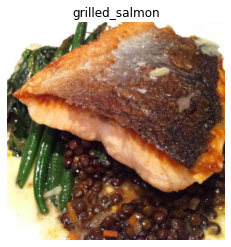

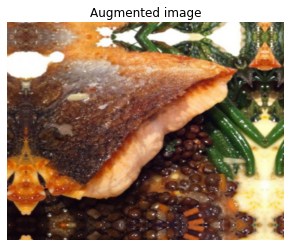

In [25]:
# View random image and compare it to it's augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read the random image
img =  mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(target_class)
plt.axis(False)

# Augment the image and visualize it.
aug_img = data_augmentation(img)
plt.figure()
plt.imshow(aug_img/255.)
plt.title(f"Augmented image")
plt.axis(False)

## Feature extraction transfer learning on 1% of the data with data augmentation

In [26]:
# Setup the input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Creating input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base model the input (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool the output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer as output layer
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model using inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile our model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_model_1 = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=(0.25*len(test_data)),
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning", 
                                                                       experiment_name="1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20220104-163247
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


3/3 [==============================] - 15s 3s/step - loss: 2.4155 - accuracy: 0.0571 - val_loss: 2.2185 - val_accuracy: 0.1922
Epoch 2/5
3/3 [==============================] - 7s 3s/step - loss: 2.1333 - accuracy: 0.2714 - val_loss: 2.0917 - val_accuracy: 0.2844
Epoch 3/5
3/3 [==============================] - 7s 3s/step - loss: 1.9563 - accuracy: 0.3857 - val_loss: 1.9837 - val_accuracy: 0.3594
Epoch 4/5
3/3 [==============================] - 6s 3s/step - loss: 1.8434 - accuracy: 0.4714 - val_loss: 1.9006 - val_accuracy: 0.4016
Epoch 5/5
3/3 [==============================] - 5s 2s/step - loss: 1.5947 - accuracy: 0.6857 - val_loss: 1.8097 - val_accuracy: 0.4625


In [27]:
model_1.evaluate(test_data)

79/79 [==============================] - 11s 126ms/step - loss: 1.8243 - accuracy: 0.4320


[1.8242876529693604, 0.4320000112056732]

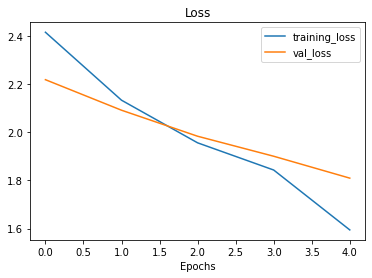

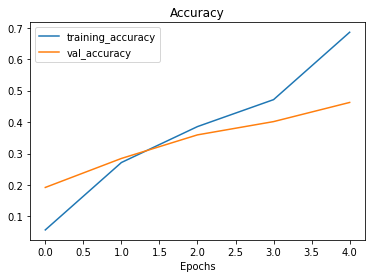

In [28]:
plot_loss_curves(history_model_1)

## Model 2: feature extraction transfer learning model with 10% of data and data augmentation

In [29]:
# Get 10% of the data
train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [30]:
# Set data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE,
                                                                            batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [31]:
# Create model 2 with data augmentation built in
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import Sequential

# Build data augmentation layer
data_augmentation = Sequential([
                                preprocessing.RandomFlip("horizontal"),
                                preprocessing.RandomHeight(0.2),
                                preprocessing.RandomWidth(0.2),
                                preprocessing.RandomZoom(0.2),
                                preprocessing.RandomRotation(0.2)
], name="data_augmentation")

In [32]:
# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model with EfficientNetB0
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create inputs and outputs (including layers in between)
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False) # pass augmented images to the base model, but keeps it in inderence mode
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [33]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

### Creating a ModelCheckpoint callback

The ModelCheckpoint callback intermediately saves our model (the full model or just the weights) during training.

In [34]:
# Set checkpoint path
checkpoint_path = "10_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch",
                                                         verbose=1)

In [35]:
initial_epochs = 5
history_model_2 = model_2.fit(train_data_10_percent,
                              epochs=initial_epochs,
                              steps_per_epoch=len(train_data_10_percent),
                              validation_data=test_data,
                              validation_steps=(0.25*len(test_data)),
                              callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                    experiment_name="10_percent_data_aug"), checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20220104-163356
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


24/24 [==============================] - ETA: 0s - loss: 2.0187 - accuracy: 0.3427
Epoch 00001: saving model to 10_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 26s 771ms/step - loss: 2.0187 - accuracy: 0.3427 - val_loss: 1.4943 - val_accuracy: 0.6719
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3656 - accuracy: 0.6600
Epoch 00002: saving model to 10_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 16s 654ms/step - loss: 1.3656 - accuracy: 0.6600 - val_loss: 1.0607 - val_accuracy: 0.7578
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0636 - accuracy: 0.7493
Epoch 00003: saving model to 10_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 14s 572ms/step - loss: 1.0636 - accuracy: 0.7493 - val_loss: 0.8742 - val_accuracy: 0.7734
Epoch 4/5
24/24 [==============================] - ETA: 0s - loss: 0.9141 - accuracy: 0.7

In [36]:
model_0.evaluate(test_data)

79/79 [==============================] - 11s 127ms/step - loss: 0.6155 - accuracy: 0.8340


[0.6155028939247131, 0.8339999914169312]

In [37]:
results_model_2 = model_2.evaluate(test_data)
results_model_2

79/79 [==============================] - 11s 126ms/step - loss: 0.6967 - accuracy: 0.8032


[0.6967415809631348, 0.8032000064849854]

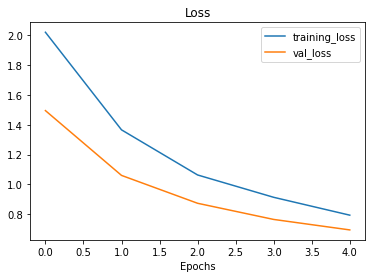

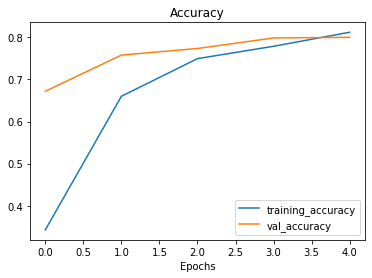

In [38]:
plot_loss_curves(history_model_2)

### Loading in checkpointed weights

Loading the checkpointed the weights returns a model to a specific checkpoint.


In [39]:
# Load in saved model weights and evaluate a model
model_2.load_weights(checkpoint_path)

In [40]:
# Evaluate model_2 with loaded weights
results_model_2_loaded_weights = model_2.evaluate(test_data)
results_model_2_loaded_weights

79/79 [==============================] - 11s 126ms/step - loss: 0.6967 - accuracy: 0.8032


[0.69674152135849, 0.8032000064849854]

In [41]:
# Check to see if the loaded model's result is close to non-loaded model's results
import numpy as np
np.isclose(np.array(results_model_2), np.array(results_model_2_loaded_weights))

array([ True,  True])

## Model 3: Fine-tuning an existing model with 10% of the data

In [42]:
# Layers in loaded model
model_2.layers

In [43]:
# Are these layers trainable?
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fe3e453ee10> True
<keras.engine.sequential.Sequential object at 0x7fe3e448fa90> True
<keras.engine.functional.Functional object at 0x7fe3e3fc8750> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7fe3e4066b10> True
<keras.layers.core.dense.Dense object at 0x7fe3e448f850> True


In [44]:
# Layers in base model and are they trainable?
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [45]:
# How many trainable variables in base model
print(len(model_2.layers[2].trainable_variables))

0


In [46]:
# To begin fne-tuning. let's start by setting the last 10 layer as trainable
base_model.trainable = True

for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile (We have to recompile after we make a change to the model)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # When fine-tunning, typically we have to lower the learning rate by 10x
                metrics=["accuracy"])

In [47]:
# Check which layers are tunable
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [48]:
print(len(model_2.trainable_variables))

12


In [49]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model
history_model_3 = model_2.fit(train_data_10_percent,
                              epochs=fine_tune_epochs,
                              validation_data=test_data,
                              validation_steps=int(0.25*len(test_data)),
                              initial_epoch=history_model_2.epoch[-1],
                              callbacks=[create_tensorboard_callback(dir_name="transfer_learning", 
                                                                     experiment_name="10_percent_fine_tune_last_10_layers")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10_layers/20220104-163635


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 5/10
24/24 [==============================] - 25s 679ms/step - loss: 0.7040 - accuracy: 0.8040 - val_loss: 0.5737 - val_accuracy: 0.8158
Epoch 6/10
24/24 [==============================] - 16s 662ms/step - loss: 0.5531 - accuracy: 0.8320 - val_loss: 0.5353 - val_accuracy: 0.8257
Epoch 7/10
24/24 [==============================] - 17s 658ms/step - loss: 0.5195 - accuracy: 0.8333 - val_loss: 0.5360 - val_accuracy: 0.8322
Epoch 8/10
24/24 [==============================] - 15s 602ms/step - loss: 0.4716 - accuracy: 0.8347 - val_loss: 0.5282 - val_accuracy: 0.8273
Epoch 9/10
24/24 [==============================] - 12s 490ms/step - loss: 0.3949 - accuracy: 0.8787 - val_loss: 0.5116 - val_accuracy: 0.8322
Epoch 10/10
24/24 [==============================] - 12s 499ms/step - loss: 0.3691 - accuracy: 0.8907 - val_loss: 0.5112 - val_accuracy: 0.8355


In [50]:
# Evaluate the fine-tuned model
results_model_3 = model_2.evaluate(test_data)
results_model_3

79/79 [==============================] - 10s 125ms/step - loss: 0.4974 - accuracy: 0.8284


[0.49744853377342224, 0.8284000158309937]

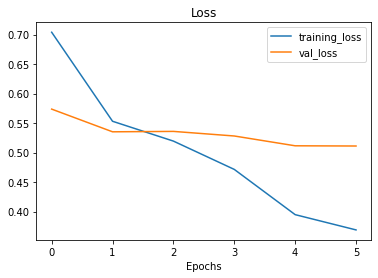

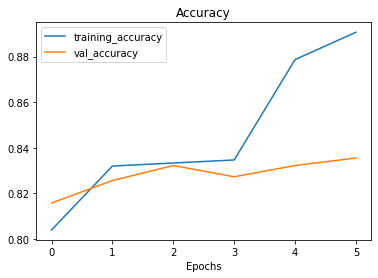

In [51]:
plot_loss_curves(history_model_3)

In [52]:
# let's create a function to compare training histories
def compare_histories(original_history, new_history, initial_epochs=5):
  """
  Compares two Tensorflow History objects
  """
  # Get original history measurements
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  # Combine original history metrics with new_history metrics
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  # Make plot for accuracy
  plt.figure(figsize=(8,8))
  plt.subplot(2,1,1)
  plt.plot(total_acc, label="Training accuracy")
  plt.plot(total_val_acc, label="Validation accuracy")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start fine tuning")
  plt.legend(loc="lower right")
  plt.title("training and Validation Accuracy")

  # Make plot for loss
  plt.figure(figsize=(8,8))
  plt.subplot(2,1,1)
  plt.plot(total_loss, label="Training Loss")
  plt.plot(total_val_loss, label="Validation Loss")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start fine tuning")
  plt.legend(loc="upper right")
  plt.title("training and Validation Loss")

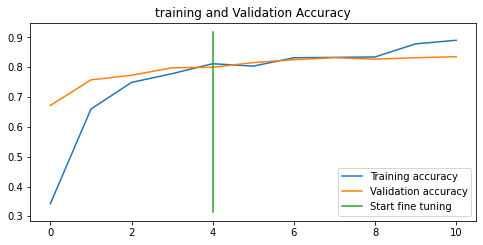

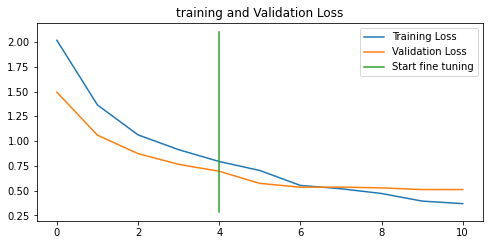

In [53]:
compare_histories(history_model_2, history_model_3, initial_epochs=5)

## Model 4: Fine-tuning and existing model with all the data 

In [54]:
# Download and unzip 10 classes of Food101 data with all the images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2022-01-04 16:38:57--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.119.128, 108.177.111.128, 142.250.1.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   214MB/s    in 2.3s    

2022-01-04 16:38:59 (214 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [55]:
# Setup training and test directories
train_dir_all_data = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [56]:
# How many images are we working with
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.

In [57]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_all_data,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [58]:
model_2.evaluate(test_data)

79/79 [==============================] - 11s 127ms/step - loss: 0.4974 - accuracy: 0.8284


[0.4974484443664551, 0.8284000158309937]

To train the model_4, we need to revert model_2 back to it's feature extraction weights

In [59]:
model_2.load_weights(checkpoint_path)

In [60]:
model_2.evaluate(test_data)

79/79 [==============================] - 11s 126ms/step - loss: 0.6967 - accuracy: 0.8032


[0.69674152135849, 0.8032000064849854]

In [61]:
# Check which layers are tunable in the whole model
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_layer True
4 output_layer True


In [62]:
# Let's drill into our base model (efficientnet)
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [63]:
# Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

In [64]:
# Train and fine-tune the model with full data
fine_tune_epochs = initial_epochs + 5
history_model_4 = model_2.fit(train_data_10_classes_full,
                              epochs=fine_tune_epochs,
                              validation_data=test_data,
                              validation_steps=int(0.25*len(test_data)),
                              initial_epoch=history_model_2.epoch[-1],
                              callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                     experiment_name="fine_tune_with_full_data")])

Saving TensorBoard log files to: transfer_learning/fine_tune_with_full_data/20220104-163950
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


235/235 [==============================] - 98s 382ms/step - loss: 0.7277 - accuracy: 0.7676 - val_loss: 0.4438 - val_accuracy: 0.8536
Epoch 6/10
235/235 [==============================] - 75s 315ms/step - loss: 0.5892 - accuracy: 0.8119 - val_loss: 0.3869 - val_accuracy: 0.8602
Epoch 7/10
235/235 [==============================] - 72s 303ms/step - loss: 0.5327 - accuracy: 0.8316 - val_loss: 0.3676 - val_accuracy: 0.8849
Epoch 8/10
235/235 [==============================] - 67s 281ms/step - loss: 0.4907 - accuracy: 0.8427 - val_loss: 0.3694 - val_accuracy: 0.8882
Epoch 9/10
235/235 [==============================] - 62s 260ms/step - loss: 0.4520 - accuracy: 0.8567 - val_loss: 0.3275 - val_accuracy: 0.9013
Epoch 10/10
235/235 [==============================] - 59s 251ms/step - loss: 0.4289 - accuracy: 0.8595 - val_loss: 0.3410 - val_accuracy: 0.8964


In [65]:
# Let's evalauate on all of test data
model_2.evaluate(test_data)

79/79 [==============================] - 11s 137ms/step - loss: 0.3363 - accuracy: 0.8904


[0.3363475203514099, 0.8903999924659729]

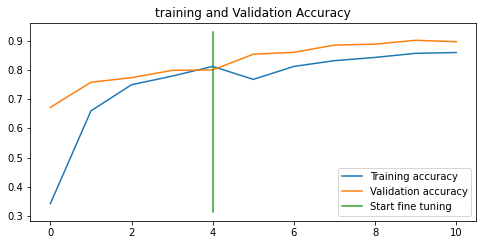

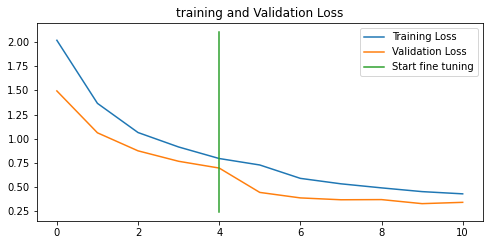

In [66]:
compare_histories(original_history=history_model_2,
                  new_history=history_model_4,
                  initial_epochs=5)

In [ ]:
# View tensorboard logs of transfer learning modelling experiments
# Upload Tensorboard dev records
!tensorboard dev upload --logdir ./transfer_learning \
--name "Transfer Learning experiments with Food101 classes" \
--description "A series of different transfer learning experiments with varyinng amount of data and fine-tuning" \
--one_shot # exits the uploader once it's finished the uploading

In [69]:
# View all of your uploaded tensorboard experimentsyes
!tensorboard dev list

https://tensorboard.dev/experiment/MJ5Vx9PuQDqexrVjQvxXag/
	Name                 Transfer Learning experiments with Food101 classes
	Description          A series of different transfer learning experiments with varyinng amount of data and fine-tuning--one_shot
	Id                   MJ5Vx9PuQDqexrVjQvxXag
	Created              2022-01-04 16:49:00 (5 minutes ago)
	Updated              2022-01-04 16:49:05 (5 minutes ago)
	Runs                 10
	Tags                 5
	Scalars              162
	Tensor bytes         0
	Binary object bytes  4152288
Total: 1 experiment(s)


In [70]:
!tensorboard dev delete --experiment_id MJ5Vx9PuQDqexrVjQvxXag

Deleted experiment MJ5Vx9PuQDqexrVjQvxXag.
